# 正则化 --- 从0开始

本章从0开始介绍如何的正则化来应对[过拟合](underfit-overfit.md)问题。

## 高维线性回归

我们使用高维线性回归为例来引入一个过拟合问题。


具体来说我们使用如下的线性函数来生成每一个数据样本

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \text{noise}$$

这里噪音服从均值0和标准差为0.01的正态分布。

需要注意的是，我们用以上相同的数据生成函数来生成训练数据集和测试数据集。为了观察过拟合，我们特意把训练数据样本数设低，例如$n=20$，同时把维度升高，例如$p=200$。

In [1]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

num_train = 20
num_test = 100
num_inputs = 200

## 生成数据集


这里定义模型真实参数。

In [2]:
true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

我们接着生成训练和测试数据集。

In [3]:
X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w)
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

当我们开始训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数它每次返回`batch_size`个随机的样本和对应的目标。我们通过python的`yield`来构造一个迭代器。

In [4]:
import random
batch_size = 1
def data_iter(num_examples):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield X.take(j), y.take(j)

## 初始化模型参数

下面我们随机初始化模型参数。之后训练时我们需要对这些参数求导来更新它们的值，所以我们需要创建它们的梯度。

In [5]:
def get_params():
    w = nd.random.normal(shape=(num_inputs, 1))*0.1
    b = nd.zeros((1,))
    for param in (w, b):
        param.attach_grad()
    return (w, b)

## $L_2$范数正则化

这里我们引入$L_2$范数正则化。不同于在训练时仅仅最小化损失函数(Loss)，我们在训练时其实在最小化

$$\text{loss} + \lambda \sum_{p \in \textrm{params}}\|p\|_2^2。$$

直观上，$L_2$范数正则化试图惩罚较大绝对值的参数值。下面我们定义L2正则化。注意有些时候大家对偏移加罚，有时候不加罚。通常结果上两者区别不大。这里我们演示对偏移也加罚的情况：

In [6]:
def L2_penalty(w, b):
    return (w**2).sum() + b**2

## 定义训练和测试

下面我们定义剩下的所需要的函数。这个跟之前的教程大致一样，主要是区别在于计算`loss`的时候我们加上了L2正则化，以及我们将训练和测试损失都画了出来。

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def net(X, lambd, w, b):
    return nd.dot(X, w) + b

def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad
        
def test(params, X, y):
    return square_loss(net(X, 0, *params), y).mean().asscalar()

def train(lambd):
    epochs = 10
    learning_rate = 0.002
    params = get_params()
    train_loss = []
    test_loss = []
    for e in range(epochs):        
        for data, label in data_iter(num_train):
            with autograd.record():
                output = net(data, lambd, *params)
                loss = square_loss(
                    output, label) + lambd * L2_penalty(*params)
            loss.backward()
            SGD(params, learning_rate)
        train_loss.append(test(params, X_train, y_train))
        test_loss.append(test(params, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return 'learned w[:10]:', params[0][:10], 'learend b:', params[1]

## 观察过拟合

接下来我们训练并测试我们的高维线性回归模型。注意这时我们并未使用正则化。

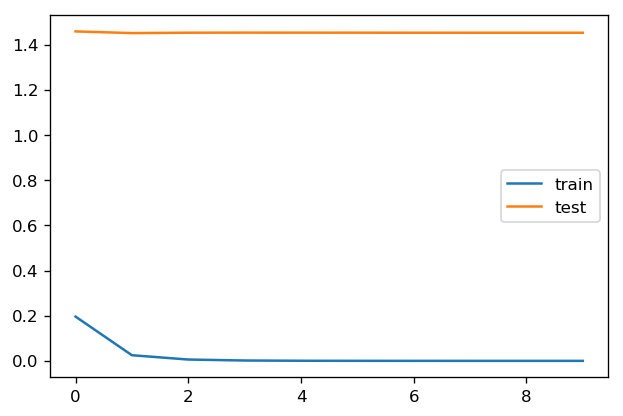

('learned w[:10]:', 
 [[ 0.03794683]
  [ 0.06871992]
  [ 0.06909655]
  [ 0.01793571]
  [ 0.05761081]
  [ 0.09157518]
  [-0.02597325]
  [-0.15014179]
  [-0.09125998]
  [ 0.05193319]]
 <NDArray 10x1 @cpu(0)>, 'learend b:', 
 [-0.03267186]
 <NDArray 1 @cpu(0)>)

In [8]:
train(0)

即便训练误差可以达到0.000000，但是测试数据集上的误差很高。这是典型的过拟合现象。

观察学习的参数。事实上，大部分学到的参数的绝对值比真实参数的绝对值要大一些。


## 使用正则化

下面我们重新初始化模型参数并设置一个正则化参数。

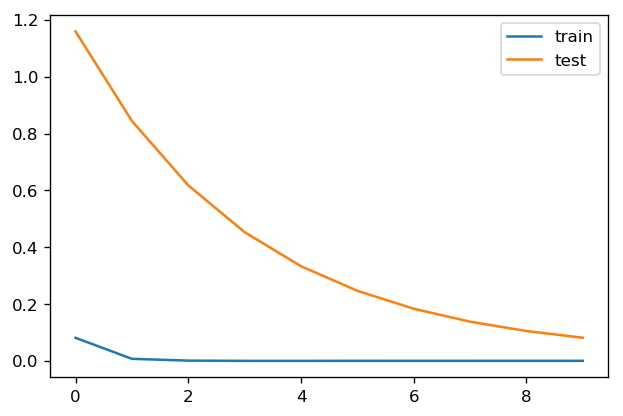

('learned w[:10]:', 
 [[ 0.0139041 ]
  [ 0.01057856]
  [ 0.0074094 ]
  [ 0.04134962]
  [-0.00725697]
  [ 0.02789255]
  [ 0.040944  ]
  [-0.00626271]
  [ 0.00752906]
  [-0.0319235 ]]
 <NDArray 10x1 @cpu(0)>, 'learend b:', 
 [-0.00081068]
 <NDArray 1 @cpu(0)>)

In [9]:
train(2)

我们发现训练误差虽然有所提高，但测试数据集上的误差有所下降。过拟合现象得到缓解。但打印出的学到的参数依然不是很理想，这主要是因为我们训练数据的样本相对维度来说太少。

## 结论

* 我们可以使用正则化来应对过拟合问题。

## 练习

* 除了正则化、增大训练量、以及使用合适的模型，你觉得还有哪些办法可以应对过拟合现象？
* 如果你了解贝叶斯统计，你觉得$L_2$范数正则化对应贝叶斯统计里的哪个重要概念？

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/984)